In [432]:
import gymnasium as gym

import numpy as np
import torch
from torch import nn

import matplotlib.pyplot as plt

from collections import deque

from IPython.display import clear_output


In [433]:
class ESNetwork(nn.Module):
    def __init__(
        self,
        in_size,
        out_size,
        hidden_size=8,

        pop_size=5,
        
        use_grad=False
    ):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, out_size)
        )
            
        # parent weights (parameters?)
        self.master_weights = [param.data for param in self.parameters()]
        self.pop_size = pop_size
        self.populate()

        # controls noise rate?
        self.sigma = 0.1
        self.lr = 1e-4

        # pytorch has it on by default - we won't use it so disable it
        if not use_grad:
            map(lambda param: param.requires_grad_(False), self.parameters())
    
    def forward(self, x):
        return self.layers(x)
    
    def set_individual(self, individual_idx):
        """change which individual, and therefore parameters, are being used"""
        assert 0 <= individual_idx < self.pop_size
        # self.parameters() is a generator not a tensor so we need to do this
        for p_group, param in enumerate(self.parameters()):
            noise = self.sigma * self.population[individual_idx][p_group]
            # TODO: check if this outputs float
            # add noise from parent
            param.data = self.master_weights[p_group] + noise

    # def forward_individual(self, x, individual_idx):
    #     """forward using the set of parameters of an individual"""
    #     assert 0 <= individual_idx < self.pop_size
    #     # set params to be used on forward pass
    #     self.params = self.population[individual_idx]
    #     return self._forward(x)

    # https://discuss.pytorch.org/t/how-to-re-set-alll-parameters-in-a-network/20819/2
    def reset_weight(m):
        if isinstance(m, nn.Linear):
            m.reset_parameters()


    def populate(self):
        """create population with random weights"""
        # NOTE: this is NOT creating random parameters, but rather WEIGHTS
        # for i in range(self.population):
        #     self.layers.apply(self.reset_weight)
        #     self.population[i] 
        self.population = []
        for _ in range(self.pop_size):
            idv_weights = []
            for params in self.parameters():
                # generate params for param group of individual
                # TODO: init from self.reset_weight
                idv_weights.append(torch.randn(params.shape))
            self.population.append(idv_weights)

    def add_noise_to_weights(self):
        """basically, create offsprings with gaussian noise distribution"""
        for individual in range(self.pop_size):
            # self.parameters() is a generator not a tensor so we need to do this
            for p_group, param in enumerate(self.parameters()):
                noise = self.sigma * self.population[individual][p_group]
                # add noise from parent
                param.data = self.master_weights[p_group] + noise
    
    def evolve(self, rewards):
        # avoid math error I think?
        if torch.std(rewards) != 0:
            normalized_rewards = (rewards - torch.mean(rewards)) / torch.std(rewards)
            # I think we don't have to subtract parameters by parents or a mean because we 
            # already normalize them by rewards (normalized_rewards)?
            for p_group, param in enumerate(self.parameters()):
                    # group of parameters for each individual, has shape (population_size, *params[p_type].size)
                    A = torch.stack([individual[p_group] for individual in self.population])
                    # scale each individual's weights by its performance
                    '''
                    funny pytorch moment
                    we have A.shape = [pop_size, *param_size] and rewards.shape = [pop_size]
                    for the product to work we need to create singleton dimensions on rewards
                    problem is, some params are 2D, others are 1D, so we do this to generalize
                    '''
                    # pytorch gets funky here because we need the shapes
                    param_singletons = [1] * param.dim()
                    weighted_param_update = A * normalized_rewards.view(-1, *param_singletons)
                    # sum all individual's weights
                    weighted_param_update = weighted_param_update.sum(dim=0)
                    param.data = self.master_weights[p_group] + self.lr / (self.pop_size * self.sigma) * weighted_param_update

        # TODO: adaptive lr
        # hs = torch.max(rewards)
        # self.lr = self.lr * 5 + (self,.target - torch.mean)

SyntaxError: invalid syntax (1722718223.py, line 106)

In [ ]:
class ESAgent:
    def __init__(self,
        env: gym.Env,
        hidden_layer_size=8,
        population_size=5,
        seed=123,
    ):
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        
        self.env = env
        self.seed = seed
        self.pop_size = population_size
        
        self.obs_size = env.observation_space.shape[0]
        self.action_size = env.action_space.n
        self.hidden_layer_size = hidden_layer_size
        self.init_nn()

        self.is_test = False

        self.gen_scores = np.empty(self.pop_size)

        print('device:', self.device)

    def init_nn(self):
        self.nn = ESNetwork(self.obs_size, self.action_size, self.hidden_layer_size, self.pop_size).to(self.device)

    def choose_action(self, state):
        state = torch.from_numpy(state)
        selected_action = self.nn(state).argmax().item()
        return selected_action
    
    def take_step(self, action):
        next_state, reward, terminated, truncated, _ = self.env.step(action)
        is_done = terminated or truncated
        
        return next_state, reward, is_done
    
    def train_ep(self, individual):
        state, _ = self.env.reset(seed=self.seed)
        self.seed += 1
        ep_score = 0
        self.nn.set_individual(individual)
        for s in range(max_steps):
            action = self.choose_action(state)
            next_state, reward, is_done = self.take_step(action)
            
            ep_score += reward
            if is_done:
                break
            state = next_state
        return ep_score

    def train(self, max_eps=200, plotting_interval=10):
        self.is_test = False

        # self.train_ep does it instead B)
        # state, _ = self.env.reset(seed=seed)

        # ma: mean average
        scores = []
        short_ma = deque(maxlen=5)
        long_ma = deque(maxlen=10)

        pop_idxs = range(self.pop_size)
        try:
            for ep in range(1, max_eps+1):
                # I think I made it very easy to make this paraleli.. parallelizable? word
                # I don't know how to create multiple gym envs though
                # with ThreadPool(processes=self.pop_size) as pool:
                #     scores = pool.map(train_ep, pop_idxs)
                ep_scores = [self.train_ep(idv) for idv in pop_idxs]
                scores.append(ep_scores)
                ep_scores = torch.FloatTensor(ep_scores, device=self.device)
                self.nn.evolve(ep_scores)
                self.nn.add_noise_to_weights()
                
                if ep % 10 == 0:
                    # has it been doing worse in the short term than in the long(er) term?
                    if np.mean(short_ma) < np.mean(long_ma):
                        self.init_nn()
                        short_ma.clear()
                        long_ma.clear()

                if ep % plotting_interval == 0:
                    self._plot(ep, scores)

        except KeyboardInterrupt:
            pass
            # self.save_state('saved-state-undone')
        else:
            pass
            # self.save_state()
        self.env.close()

    def populate(self):
        self.population = np.empty(self.POPULATION_SIZE)
        
    
    def save_state(self, fname='saved-state'):
        state_dict = self.dqn.state_dict()
        torch.save(state_dict, f'saved-states/{fname}.s{self.seed}.pt')
        print('saved state!')
        return state_dict

    def load_state(self, state_dict):
        self.dqn.load_state_dict(state_dict)
        return state_dict
    
    def seed(seed=123):
        pass
        # TODO
        
    def test(self):
        pass
        # TODO
  
    def _plot(self, ep, scores):
        clear_output(wait=True)
        # fig, (ax1,) = plt.subplots(1,1, figsize=(20, 5), num=1, clear=True)
        fig, ax1 = plt.subplots(1,1, num=1, clear=True)

        ax1.set_title(f'episode {ep}')
        ax1.fill_between(range(len(scores)), np.max(scores, axis=-1), np.min(scores, axis=-1), alpha=0.5)
        ax1.plot(np.mean(scores, axis=-1))

        plt.show()


In [ ]:
env_id = "CartPole-v1"
env = gym.make(env_id)

hidden = 8
pop_size = 5
max_eps = 30_000
max_steps = 200

agent = ESAgent(env, hidden, pop_size)

device: cpu


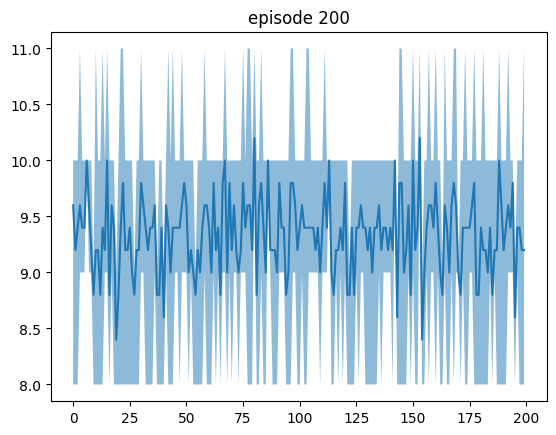

In [ ]:
agent.train()